# An Introduction to Models in Pyro

In [26]:
# I cannot find documentation for pyro functions, so I will use definition of similiar TensorFlow functions
import torch
import pyro



# Sets the graph-level random seed
pyro.set_rng_seed(101)



## Primitive Stochastic Functions

In [27]:
# Create a normal distribution and draw a sample from it
#___________________________________________________________________________________________________________________________

# Mean zero
loc = 1

# Unit variance
scale = 1

# Create a normal distribution object 
normal = torch.distributions.Normal(loc, scale)

# Draw a sample from N(0,1)
x = normal.rsample()

print(normal)

# Print sample
print("sample: ",x)

# Score the sample from N(0,1)
print("log prob: ",normal.log_prob(x))
# Log probability is simply the logarithm of a probability.
# Representing probabilities in this way has several practical advantages, such as speed, accuracy and simplicity.

Normal(loc: 1.0, scale: 1.0)
sample:  tensor(-0.3905)
log prob:  tensor(-1.8857)


## A Simple Model

In [28]:
# Create a simple stochastic function that describes how temperature interacts with whether it was sunny or cloudy on a day
#___________________________________________________________________________________________________________________________

def weather():
    # Create a Bernoulli distribution and sample from it, so our sample is either a 1 or 0
    # 0.3 = 30% chance of a 1, and 70% chance of a 0
    cloudy = torch.distributions.Bernoulli(0.3).sample()
    # If our sample is 1, then we say it was "cloudy", else it was "sunny"
    cloudy = "cloudy" if cloudy.item() == 1.0 else "sunny"
    
    # Create a dicstrionary with the sky attributes as keys, and the values are the temperature
    # At the same time, we acces a value by reffering to the key [cloudy]. This value is our temperature mean
    # Note that cloudy days have a lower mean temperature
    mean_temp = {"cloudy": 55.0, "sunny": 75.0}[cloudy]
    
    # Same as above, but this is our variance for the temperature
    scale_temp = {"cloudy": 10.0, "sunny": 15.0}[cloudy]
    
    # Create a normal distribution for the temperature, giving it our mean and variance we calculated above
    # We immidently sample from it
    temp = torch.distributions.Normal(mean_temp, scale_temp).rsample()
    
    # Return sky attribute with the temperature
    return cloudy, temp.item()
    
for i in range(0,10):
    print(weather())
    

('cloudy', 46.847618103027344)
('cloudy', 53.20433807373047)
('sunny', 91.11004638671875)
('cloudy', 52.48044204711914)
('sunny', 68.44023895263672)
('sunny', 80.18768310546875)
('cloudy', 54.89055252075195)
('sunny', 42.057411193847656)
('cloudy', 52.833702087402344)
('sunny', 80.13694763183594)


## The pyro.sample Primitive

In [29]:
# So far what we have done have been independent of Pyro. We will now rewrite our weather function, such that it can
# be used for something else than just sampling fake data.
#___________________________________________________________________________________________________________________________

# Create a named pyro sample which we call "my_sample".
# Pyro's backend uses the sample names to uniquely identify statements and change their behavior at runtime
# depending on how the enclosing stochastic function is being used.
x = pyro.sample("my_sample", pyro.distributions.Normal(loc,scale))

def weather():
    # Create a Bernoulli distribution and sample from it, so our sample is either a 1 or 0
    # 0.3 = 30% chance of a 1, and 70% chance of a 0
    cloudy = pyro.sample("cloudy", pyro.distributions.Bernoulli(0.3))
    # If our sample is 1, then we say it was "cloudy", else it was "sunny"
    cloudy = "cloudy" if cloudy.item() == 1.0 else "sunny"
    
    # Create a dicstrionary with the sky attributes as keys, and the values are the temperature
    # At the same time, we acces a value by reffering to the key [cloudy]. This value is our temperature mean
    # Note that cloudy days have a lower mean temperature
    mean_temp = {"cloudy": 55.0, "sunny": 75.0}[cloudy]
    
    # Same as above, but this is our variance for the temperature
    scale_temp = {"cloudy": 10.0, "sunny": 15.0}[cloudy]
    
    # Create a normal distribution for the temperature, giving it our mean and variance we calculated above
    # We immidently sample from it
    temp = pyro.sample("temp", pyro.distributions.Normal(mean_temp, scale_temp))
    
    # Return sky attribute with the temperature
    return cloudy, temp.item()
    
for i in range(0,10):
    print(weather())
    

# Because the randomness is now invoked with pyro.sample, it now specifies a joint probability distribution two
# named random variable: "cloudy" and temp. As such, it defines a probabillistic model that we can reason about
# using the techniques of probability theory.

# For example we might ask: if I observe a temperature of 70 degrees, how likely is it to be cloudy?
# The next tutorial will cover hos to formulate and answer these questions.








('sunny', 76.62906646728516)
('cloudy', 42.30691146850586)
('sunny', 55.182289123535156)
('sunny', 65.34877014160156)
('cloudy', 66.43797302246094)
('cloudy', 57.695831298828125)
('cloudy', 66.84027099609375)
('sunny', 66.80554962158203)
('sunny', 84.97631072998047)
('cloudy', 62.22285842895508)


## Universality: Stochastic Recursion, Higher-order Stochastic Functions, and Random Control Flow

In [30]:
# Create a model for expected sales of ice creams, using our previous weather function.
#___________________________________________________________________________________________________________________________


def ice_cream_sales():
    # Getting the sky attribute and temperature for the day
    cloudy, temp = weather()
    # If it is sunny and above 80 degrees, then we expect to sell 4 times more ice cream than normal
    expected_sales = 200 if cloudy == "sunny" and temp > 80.0 else 50
    # Create a normal distribution for the sales of ice, with the expected sales as the mean and a variance of 10.
    # Sample from it.
    ice_cream = pyro.sample("ice_cream", pyro.distributions.Normal(expected_sales, 10.0))
    
    # Return the sample of ice creams sold
    return ice_cream


for i in range(0,10):
    print(ice_cream_sales())





tensor(51.0729)
tensor(33.9623)
tensor(51.3045)
tensor(196.1405)
tensor(183.7483)
tensor(55.6039)
tensor(50.4442)
tensor(50.9286)
tensor(65.0976)
tensor(44.0715)


In [31]:
# We can construct recursive functions that terminate their recursion nondeterministically, provided we take care to 
# pass pyro.sample unique sample names whenever it’s called.

# Define a geometric distribution that counts the number of failures until the first succes.
#___________________________________________________________________________________________________________________________

# Geometric distribution = The probability distribution of the number X of Bernoulli trials needed to get one success, 
# supported on the set { 1, 2, 3, ...}

# p = probability of succes
# t = trials
def geometric(p, t=None):
    if t is None:
        t = 0
    x = pyro.sample("x_{}".format(t), pyro.distributions.Bernoulli(p))
    if x.item() == 1:
        return 0
    else:
        return 1 + geometric(p, t + 1)
    
# Printing x gives e.g tensor(0.)
# Printing x.item() gives normal float e.g 0.0

print("Number of faliures before succes: ",geometric(0.5))



Number of faliures before succes:  0


In [32]:
# Example to show that a stochastic function can accept as input or produce as output other stochastic functions
#___________________________________________________________________________________________________________________________

# Stochastic function
def normal_product(loc, scale):
    z1 = pyro.sample("z1", pyro.distributions.Normal(loc, scale))
    z2 = pyro.sample("z2", pyro.distributions.Normal(loc, scale))
    y = z1 * z2
    return y

# Another stochastic function that takes one argument and which upon execution, generates three named random variables
def make_normal_normal():
    mu_latent = pyro.sample("mu_latent", pyro.distributions.Normal(0,1))
    fn = lambda scale: normal_product(mu_latent, scale)
    return fn


# The (1.) is for the lambda expression
print(make_normal_normal()(1.))

tensor(1.5655)


# An Introduction to Inference in Pyro

In [33]:
# Setting up the imports for the tutorial
#___________________________________________________________________________________________________________________________

import matplotlib.pyplot as plt
import numpy as np
import torch

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

pyro.set_rng_seed(101)

## A Simple Example

In [34]:
# We want to figure out how much something weighs, but the scale is faulty. We will take this faultyness into account, by
# adding noise to the measurement. The noise will be a guess based on some prior knowledge about the object, like its
# density or material properties.

# What is the weight given a guess, which we sample from a normal distribution.
# Weight | guess ~ Normal(guess,1)   

# What does the measurement give us, given our guess and weight, which we sample from a normal distribution.
# Measurement | guess, weight ~ Normal(weight, 0.75)

# The following stochastic function models the above:
#___________________________________________________________________________________________________________________________

# We make a guess, but because it is a guess it is not precise, so we make a distribution with our guess as the mean
# and with a variance of 1. This way we get a more "even" guess.
# Our guess now called "weight" is used so make another normal distribution, which our scale will sample/measure from.
def scale(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    return pyro.sample("measurement", dist.Normal(weight,0.75))

print("You weigh: ", scale(60).item())


You weigh:  57.99806594848633


## Conditioning

In [35]:
# Let us look at scale again. This time, we have given the input 8.5 and gotten the output 9.5.
# We now wish to sample from the distribution of weight given the above observation.
# In other words, we want to infer the distribution:
# (Weight | guess, measurement = 9.5) ~ ?

# We can use the function pyro.condition to allow us to constrain the value of samples statements.
#___________________________________________________________________________________________________________________________

# Pyro.condition takes a model and a dictionary of observations and returns a new model that has the same input 
# and output signatures but always uses the given values at observed sample statements.
conditioned_scale = pyro.condition(scale, data={"measurement": 9.5})

# Conditioning can be deferred or parametrized with Python's lambda or def.
def deferred_conditioned_scale(measurement, *args, **kwargs):
    return pyro.condition(scale, data={"measurement": measurement})(*args,**kwargs)

print(deferred_conditioned_scale(9.5,8.5))

# We can also just pass observations 
def scale_obs(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    
    return pyro.sample("measurement", dist.Normal(weight, 1.0), obs=9.5)

9.5


## Flexible Approximate Inference With Guide Functions

In [36]:
# For our scale example, we can calulate the posterior distribution to be Normal(9.14,0.6) by deriving it from the formulas
# in 3.4 http://www.stat.cmu.edu/~brian/463-663/week09/Chapter%2003.pdf

# The perfect model is therefore:
#___________________________________________________________________________________________________________________________


def perfect_guide(guess):
    loc = (0.75**2 * guess + 9.5) / (1 + 0.75**2) # 9.14
    scale = np.sqrt(0.75**2/(1 + 0.75**2)) # 0.6
    return pyro.sample("weight", dist.Normal(loc,scale))

for i in range(0,10):
    print(perfect_guide(60).item())

28.122642517089844
26.62798309326172
28.041976928710938
27.528827667236328
27.41761016845703
27.336336135864258
25.758628845214844
28.017961502075195
27.80918312072754
26.36229705810547


## Parametrized Stochastic Functions and Variational Inference

In [37]:
# Using a non-linear function in the middle.
#___________________________________________________________________________________________________________________________

def intractable_scale(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    return pyro.sample("measurement", dist.Normal(some_nonlinear_function(weight), 0.75))

In [38]:
# Example of 
#___________________________________________________________________________________________________________________________

simple_param_store ={}
a = simple_param_store.setdefault("a", torch.randn(1))

In [39]:
# 
#___________________________________________________________________________________________________________________________

def scale_parametrized_guide(guess):
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.0))
    return pyro.sample("weight", dist.Normal(a, torch.abs(b)))

In [40]:
# Makin the same as above, but instead of ensuring our b is positive by doing abs(), we make a constraint instead
#___________________________________________________________________________________________________________________________

from torch.distributions import constraints

def scale_parametrized_guide_constrained(guess):
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.0), constraints=constraints.positive)
    return pyro.sample("weight",dist.Normal(a, b)) # No more torch.abs()

C:\Users\Hakan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


a =  0.6043363213539124
b =  9.177616119384766


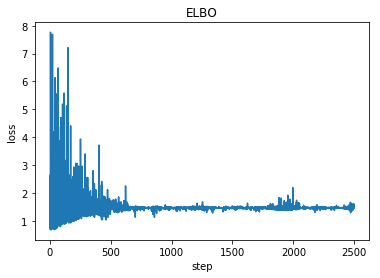

In [42]:
# 
#___________________________________________________________________________________________________________________________

guess = torch.tensor(8.5)

pyro.clear_param_store()
svi = pyro.infer.SVI(model=conditioned_scale,
                     guide=scale_parametrized_guide,
                     optim=pyro.optim.SGD({"lr": 0.001, "momentum": 0.1}),
                     loss=pyro.infer.Trace_ELBO())

losses = []
a = []
b = []

num_steps = 2500
for t in range(num_steps):
    losses.append(svi.step(guess))
    a.append(pyro.param("a").item())
    b.append(pyro.param("b").item())
    
    
plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")

print("a = ", pyro.param("b").item())
print("b = ", pyro.param("a").item())

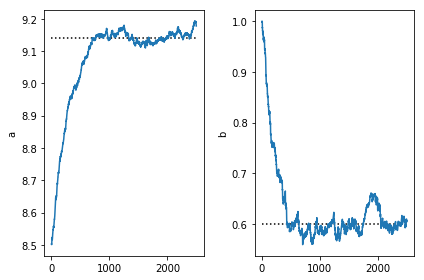

In [43]:
plt.subplot(1,2,1)
plt.plot([0,num_steps],[9.14,9.14], 'k:')
plt.plot(a)
plt.ylabel('a')

plt.subplot(1,2,2)
plt.ylabel('b')
plt.plot([0,num_steps],[0.6,0.6], 'k:')
plt.plot(b)
plt.tight_layout()